<a href="https://www.kaggle.com/code/yaaangzhou/pg-s3-e24-eda-modeling-ensemle-nn?scriptVersionId=147837399" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Created by Yang Zhou**

**[PLAYGROUND S-3,E-24]📊EDA + Modeling📈**

**24 Oct 2023**

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Binary Prediction of Smoker Status using Bio-Signals</center>
<p><center style="color:#949494; font-family: consolas; font-size: 20px;">Playground Series - Season 3, Episode 24</center></p>

***

# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Insights and Tricks</center>
- Try increasing trait `BMI`: `weight` / `height`
- Try binning a continuous variable such as different age groups: young/middle-aged/elderly
- When using neural network, the input data needs to be normalized.

**Key Observation:**


# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">Version Detail</center>
| Version | Description | Best Public Score |
|---------|-------------|-----------------|
| Version 5 | Add Features and Optimized Models |  |
| Version 4 | Add Base Model |  |
| Version 3 | Add Ensemble Model | Not Improving |
| Version 2 | Add Origin Train Dataset and Add NN | 0.86838 |
| Version 1 | Autogluon Baseline | 0.86015 |

# 0. Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

# Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV

# Models
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna

# NN
import torch
import torch.nn as nn
import torch.optim as optim
if torch.cuda.is_available():
    device = torch.device("cuda")  
else:
    device = torch.device("cpu")   
from torch.utils.data import DataLoader, TensorDataset

# Metrics 
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score, auc, confusion_matrix, classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

# 1. Load Data

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s3e24/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e24/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e24/sample_submission.csv')

origin = pd.read_csv('/kaggle/input/smoker-status-prediction-using-biosignals/train_dataset.csv')
origin.dropna(inplace=True)

# Drop column id
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

train_total = pd.concat([train, origin], ignore_index=True)

total = pd.concat([train_total, test], ignore_index=True)
# total = pd.concat([train, test], ignore_index=True)

print('The shape of the train data:', train.shape)
print('The shape of the test data:', test.shape)

print('The shape of the origin data:', origin.shape)
print('The shape of the total data:', total.shape)

The shape of the train data: (159256, 23)
The shape of the test data: (106171, 22)
The shape of the origin data: (38984, 23)
The shape of the total data: (304411, 23)


In [4]:
total.head(3)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1.0
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,0.0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1.0


In [5]:
target = 'smoking'

full_features = test.columns
num_var = [column for column in test.columns if test[column].nunique() > 10]
cat_var = [column for column in test.columns if test[column].nunique() < 10]

# 2. EDA

In [6]:
 train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
age,159256.000000,44.306626,11.842286,20.000000,40.000000,40.000000,55.000000,85.000000
height(cm),159256.000000,165.266929,8.818970,135.000000,160.000000,165.000000,170.000000,190.000000
weight(kg),159256.000000,67.143662,12.586198,30.000000,60.000000,65.000000,75.000000,130.000000
waist(cm),159256.000000,83.001990,8.957937,51.000000,77.000000,83.000000,89.000000,127.000000
eyesight(left),159256.000000,1.005798,0.402113,0.100000,0.800000,1.000000,1.200000,9.900000
eyesight(right),159256.000000,1.000989,0.392299,0.100000,0.800000,1.000000,1.200000,9.900000
hearing(left),159256.000000,1.023974,0.152969,1.000000,1.000000,1.000000,1.000000,2.000000
hearing(right),159256.000000,1.023421,0.151238,1.000000,1.000000,1.000000,1.000000,2.000000
systolic,159256.000000,122.503648,12.729315,77.000000,114.000000,121.000000,130.000000,213.000000
relaxation,159256.000000,76.874071,8.994642,44.000000,70.000000,78.000000,82.000000,133.000000


**Some observation:**

According to the introduction of the competition, the data is interpreted as follows:
- `id`: Unique identifier for each data point.
- `age`: Age of the individual, categorized in 5-year intervals.
- `height(cm)`: Height of the individual in centimeters.
- `weight(kg)`: Weight of the individual in kilograms.
- `waist(cm)`: Waist circumference of the individual in centimeters.
- `eyesight(left/right)`: Eyesight measurements for the left and right eyes.
- `hearing(left/right)`: Hearing ability for the left and right ears, represented as binary.
- `systolic`: Systolic blood pressure measurement.
- `relaxation`: Diastolic blood pressure measurement.
- `fasting blood sugar`: Fasting blood sugar level.
- `Cholesterol`: Total cholesterol level.
- `triglyceride`: Triglyceride level.
- `HDL`: High-density lipoprotein cholesterol level.
- `LDL`: Low-density lipoprotein cholesterol level.
- `hemoglobin`: Hemoglobin level in the blood.
- `Urine protein`: Level of protein in urine, categorized.
- `serum creatinine`: Serum creatinine level.
- `AST`: Level of aspartate aminotransferase enzyme.
- `ALT`: Level of alanine aminotransferase enzyme.
- `Gtp`: Level of gamma-glutamyl transferase enzyme.
- `dental caries`: Presence (1) or absence (0) of dental cavities.
- `smoking`: Target variable indicating if the individual is a smoker (1) or not (0).

In [7]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum

summary(total).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
age,int64,0,0.000000,21,304411
height(cm),int64,0,0.000000,19,304411
weight(kg),int64,0,0.000000,33,304411
waist(cm),float64,0,0.000000,551,304411
eyesight(left),float64,0,0.000000,21,304411
eyesight(right),float64,0,0.000000,20,304411
hearing(left),int64,0,0.000000,2,304411
hearing(right),int64,0,0.000000,2,304411
systolic,int64,0,0.000000,128,304411
relaxation,int64,0,0.000000,94,304411


In [8]:
summary(test).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
age,int64,0,0.000000,18,106171
height(cm),int64,0,0.000000,16,106171
weight(kg),int64,0,0.000000,26,106171
waist(cm),float64,0,0.000000,508,106171
eyesight(left),float64,0,0.000000,20,106171
eyesight(right),float64,0,0.000000,18,106171
hearing(left),int64,0,0.000000,2,106171
hearing(right),int64,0,0.000000,2,106171
systolic,int64,0,0.000000,114,106171
relaxation,int64,0,0.000000,78,106171


## Correlation

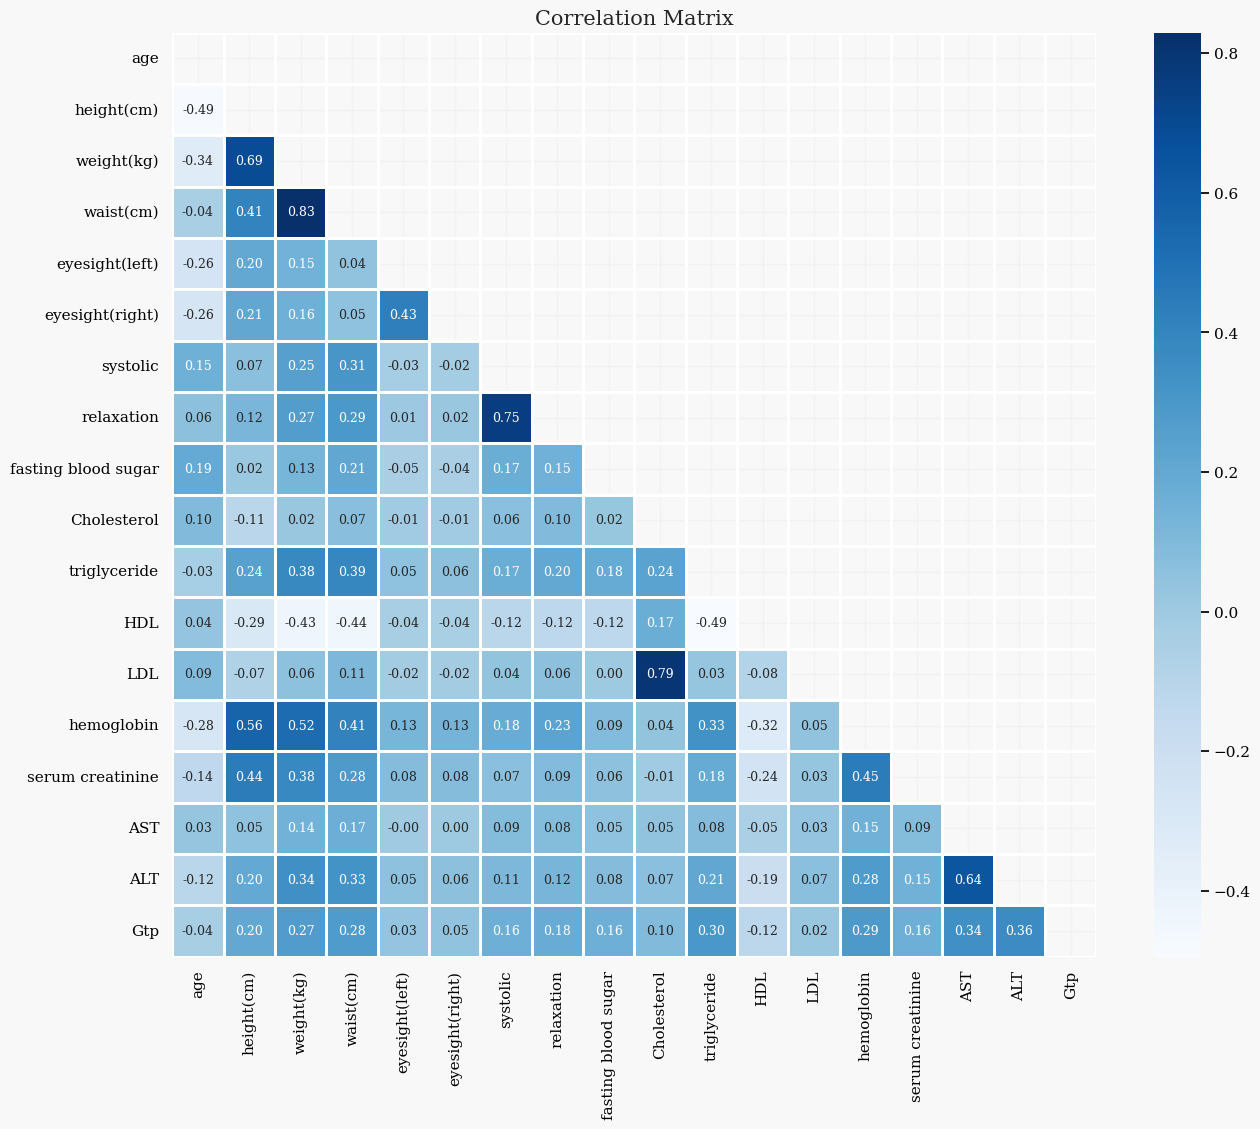

In [9]:
corr_matrix = total[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

**Some observation:**

1. We don't have highly correlated features in the total dataset.

## Scatterplot of highly correlated variables

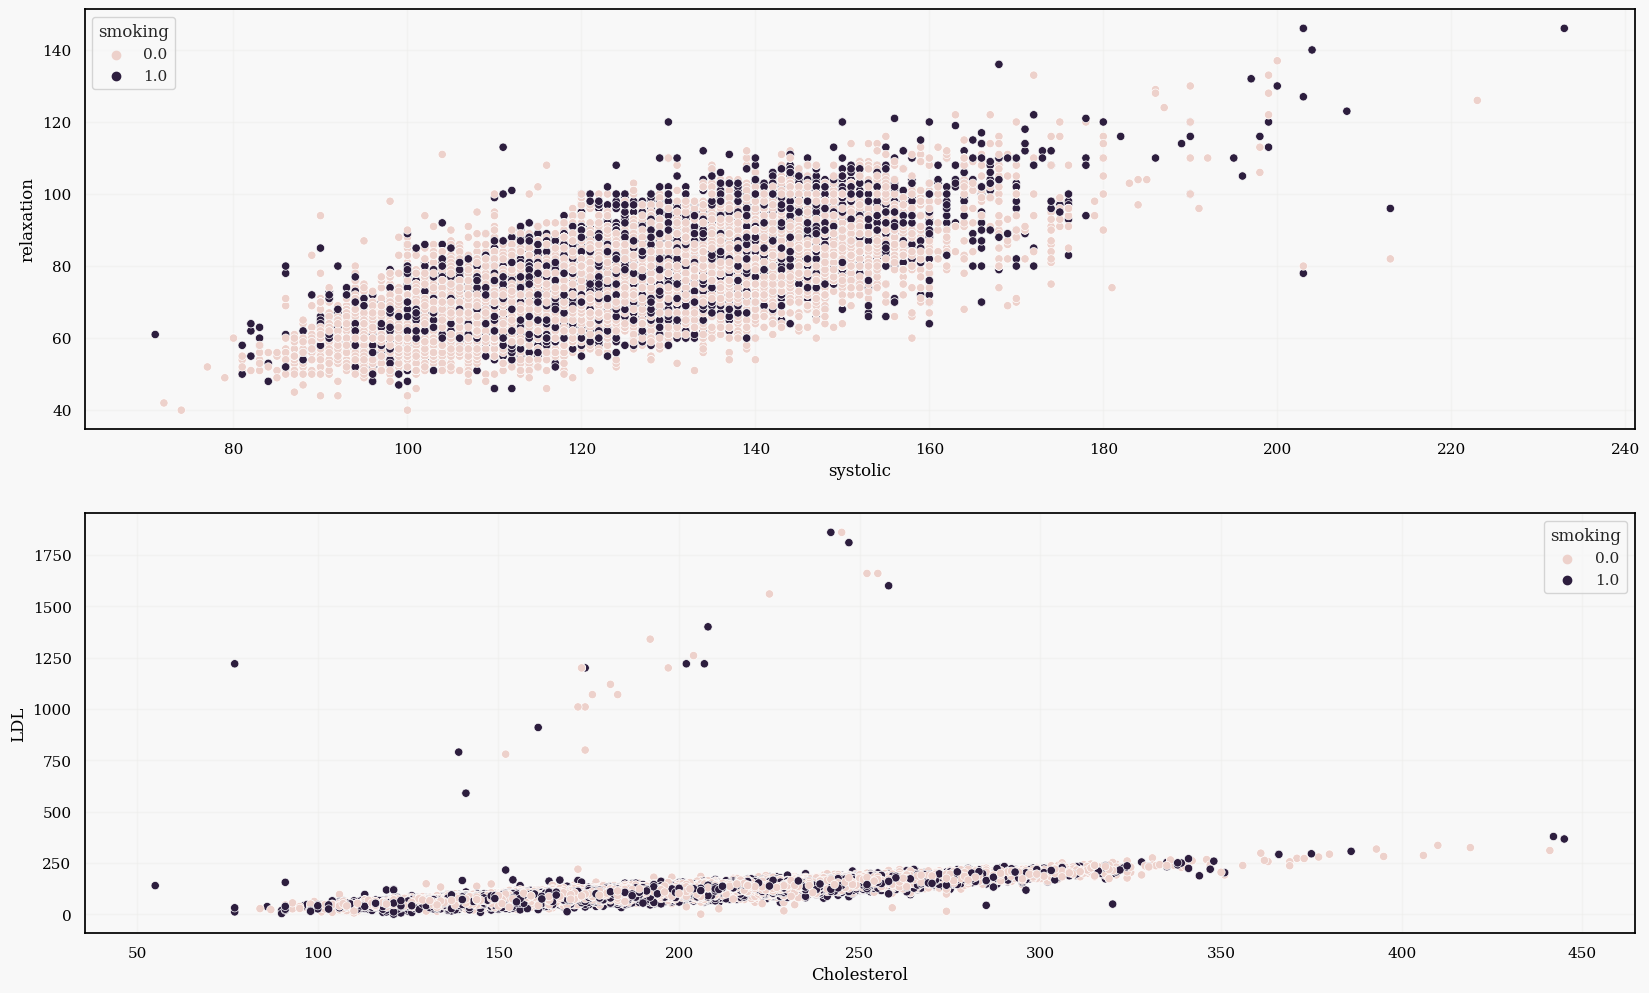

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

sns.scatterplot(ax=axes[0], data=total, x='systolic', y='relaxation', hue=target)
sns.scatterplot(ax=axes[1], data=total, x='Cholesterol', y='LDL', hue=target)

plt.show()

## Distribution of Target

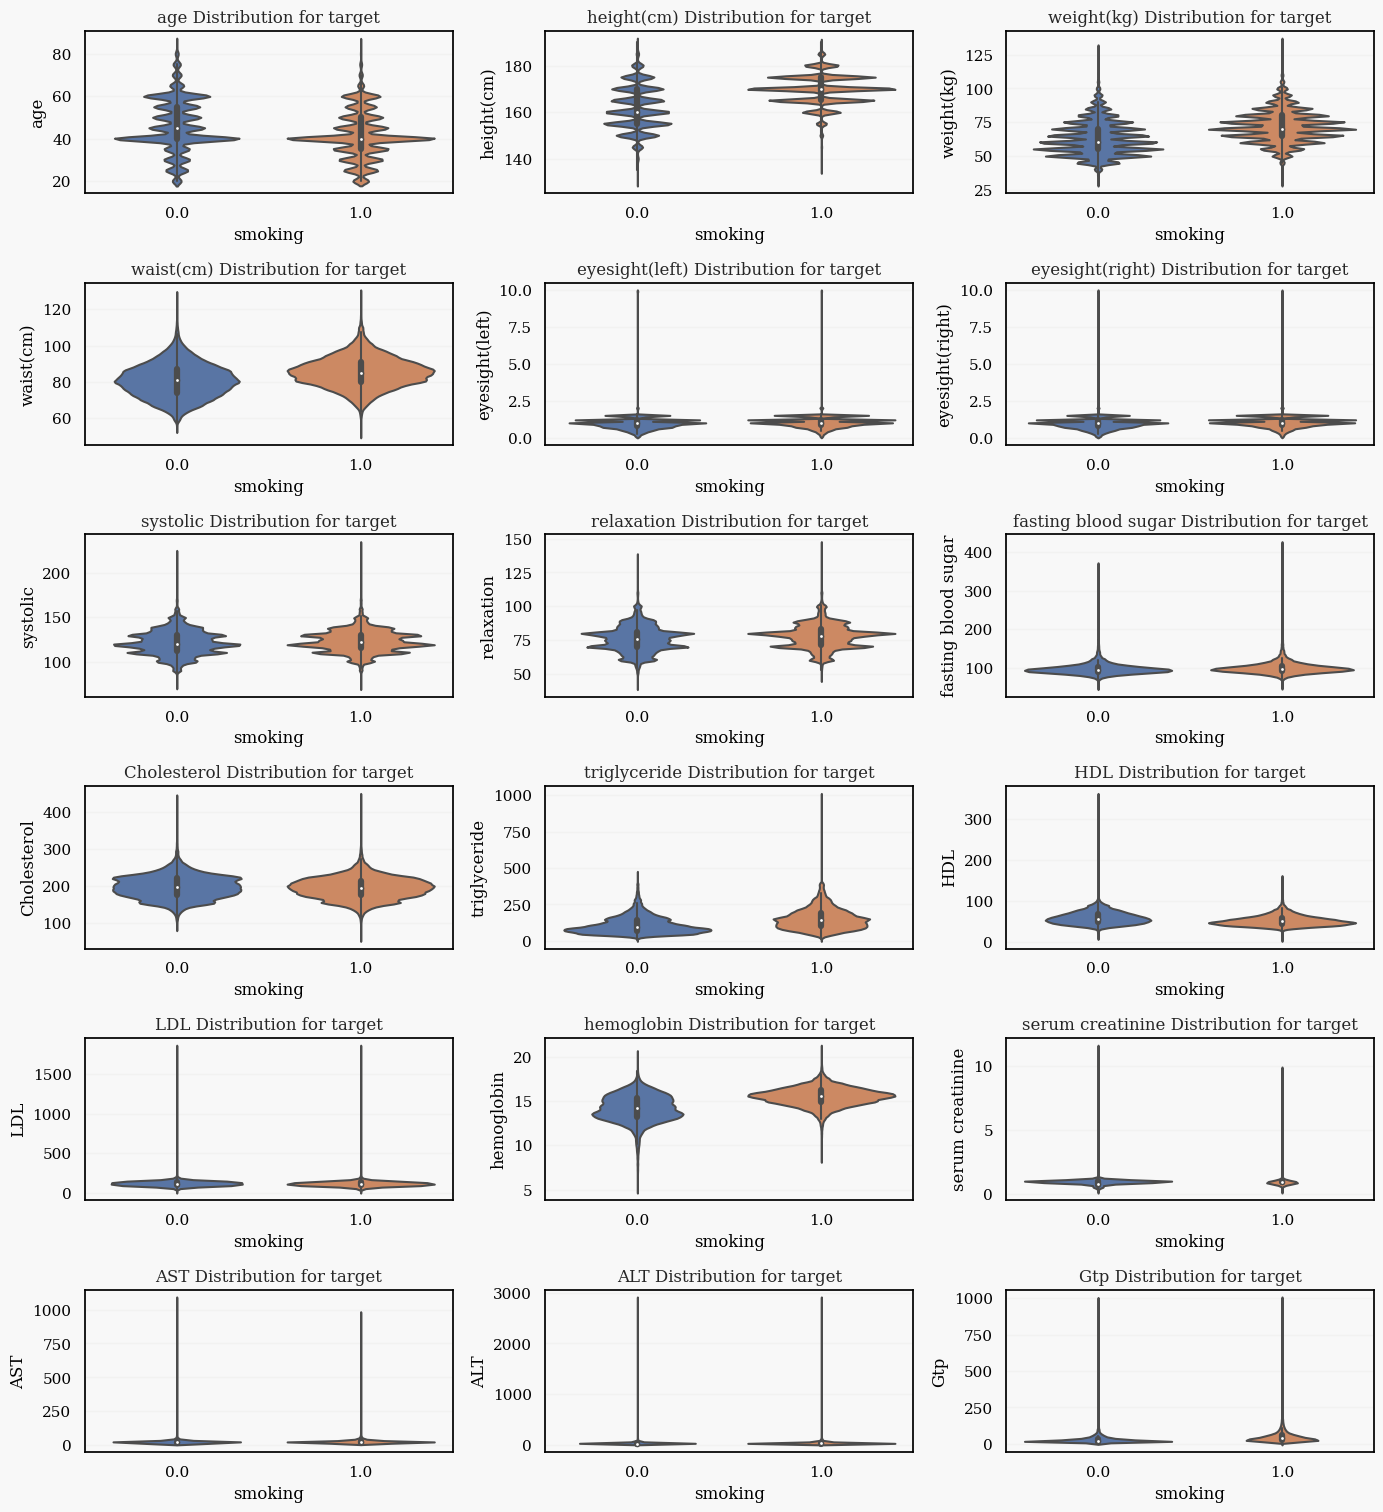

In [11]:
num_rows = len(num_var)
num_cols = 3 

total_plots = num_rows * num_cols
plt.figure(figsize=(14, num_rows * 2.5))

for idx, col in enumerate(num_var):
    plt.subplot(num_rows, num_cols, idx % total_plots + 1)
    sns.violinplot(x=target, y=col, data=total)
    plt.title(f"{col} Distribution for target")

plt.tight_layout()
plt.show()

## Distribution of Numeric Variables in Train/Test set

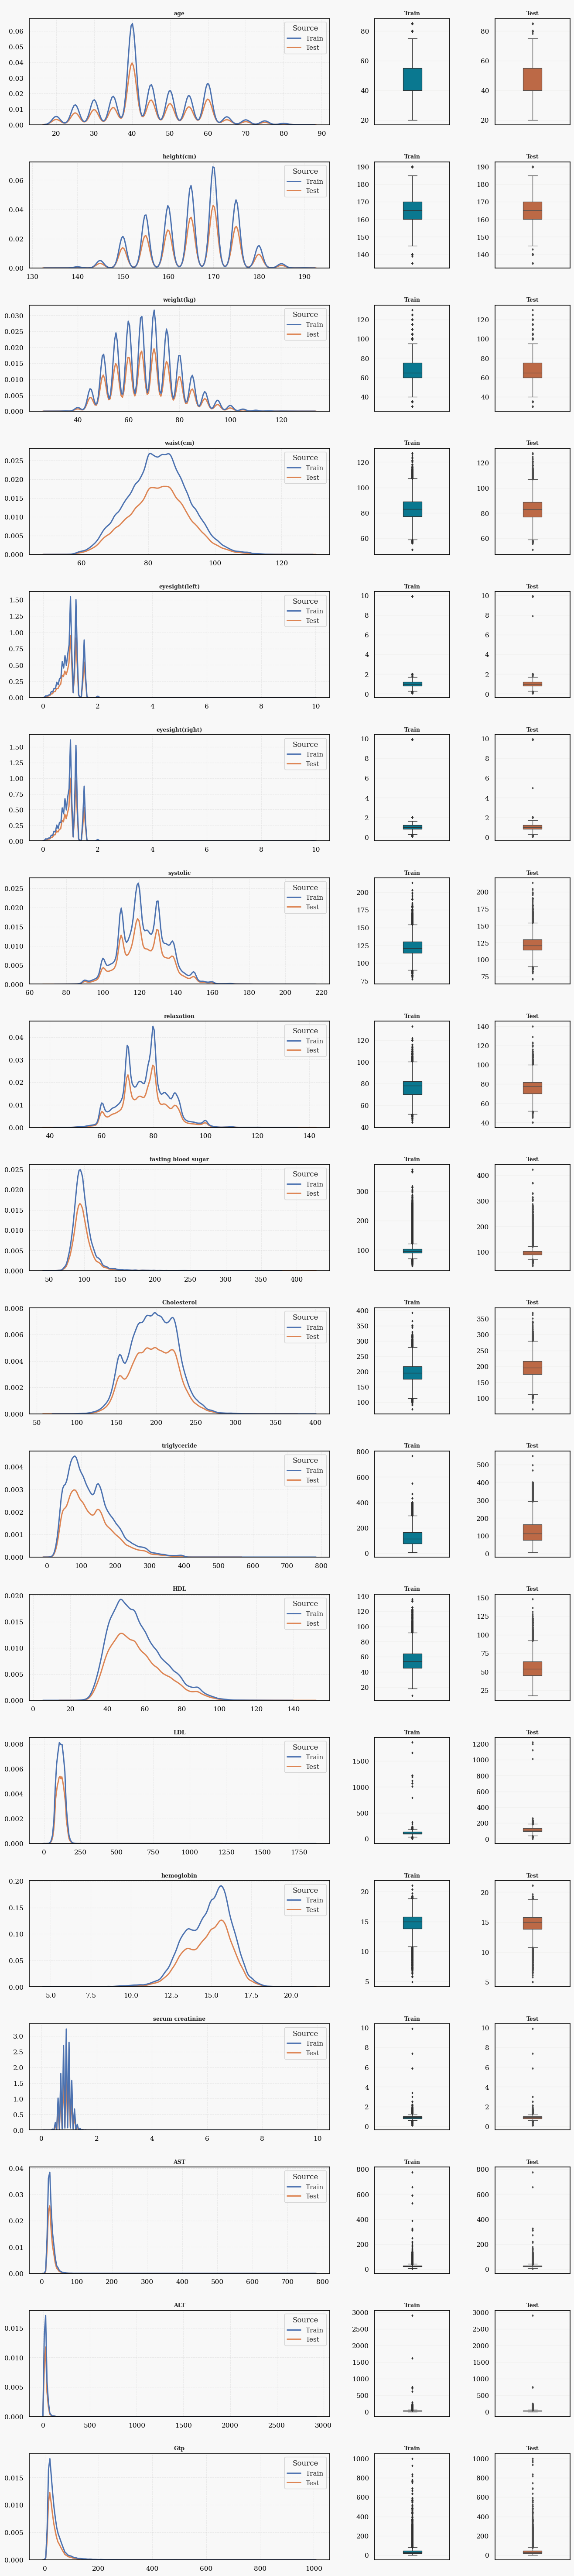

In [12]:
df = pd.concat([train[num_var].assign(Source = 'Train'), 
                test[num_var].assign(Source = 'Test')], 
               axis=0, ignore_index = True);

fig, axes = plt.subplots(len(num_var), 3 ,figsize = (16, len(num_var) * 4.2), 
                         gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');
    ax = axes[i,1];
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

    ax = axes[i,2];
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                saturation = 0.6, linewidth = 0.90, color = '#E4591E',
                ax = ax); 
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Test",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();

# 3. Features Engineering

In [13]:
# Code source: https://www.kaggle.com/code/ravi20076/playgrounds3e24-eda-baseline

def features_engineering(df):
        df= df.copy(); 
        
        df['age_risk'] = np.where(df['age'] >= 45, 1,0)
        df['BMR'] = (df['weight(kg)'] / ((df['height(cm)']/100)**2))
        df['BMR_risk']   = np.select([df['BMR'] < 18.5, df['BMR'] < 25, df['BMR'] < 30, df['BMR'] < 35, df['BMR'] < 35, df['BMR'] < 40], [0,1,2,3,4,5], 6)
        df['obesity_risk'] = np.select([df['waist(cm)'] < 80, df['waist(cm)'].between(80,88, inclusive = "both")],
                  [0,1], 2)
        df['BP_risk'] = np.select([(df['systolic'] < 120) | (df['relaxation'] < 80) , 
                                   (df['systolic'] < 130) | (df['relaxation'] < 90) ,
                                   (df['systolic'] < 140) | (df['relaxation'] < 100),
                                   (df['systolic'] < 180) | (df['relaxation'] < 120)], [0,1,2,3],4)
        df['tot_chol_risk'] = np.where(df['Cholesterol'] >= 200,1,0)
        df['HDL_risk'] = np.select([df['HDL'] >= 60, df['HDL'] >= 40], [0,1],2)
        df['LDL_risk'] = np.select([df['LDL'] < 100, df['LDL'] < 130, df['LDL'] < 160, df['LDL'] < 190], [0,1,2,3],4)
        df['tglyd_risk'] = np.select([df['triglyceride'] < 150, df['triglyceride'] < 200, df['triglyceride'] < 500], [0,1,2],3)
        df['hemoglobin_risk'] = np.where(df['hemoglobin'].between(13.8, 17.2, inclusive = "left"),0,1)
        df['creatinine_risk'] = np.where(df['serum creatinine'].between(0.74, 1.35, inclusive = "left"),1,0)
        df['Gtp_risk'] = np.where(df['Gtp'].between(5, 40, inclusive = "left"),1,0)
        df['AST_risk'] = np.where(df['AST'].between(8, 45, inclusive = "left"),1,0) 
        df['ALT_risk'] = np.where(df['ALT'].between(8, 45, inclusive = "left"),1,0)
        return df 

In [14]:
def corr_skew_outliner(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.95)
        df.loc[df[col] < Q1, col] = Q1
        df.loc[df[col] > Q3, col] = Q3
        df[col] = np.sqrt(df[col])
        
    return df

In [15]:
total = features_engineering(total)
total = corr_skew_outliner(total,num_var)

In [16]:
df_train = total[total[target].notna()]

df_test = total[total[target].isna()]
df_test = df_test.copy()
df_test.drop(target, axis=1, inplace=True)

## Baseline Model

In [17]:
lgbm_baseline = LGBMClassifier()

roc_results = pd.DataFrame(columns=['Selected_Features', 'ROC'])

def evaluation(df, select_features, note):
    global roc_results
    
    X = df[select_features]
    Y = df[target]
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    roc_scores = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
        
        lgbm_baseline.fit(X_train, y_train)
        y_hat = lgbm_baseline.predict_proba(X_test)[:, 1] 
        roc = roc_auc_score(y_test, y_hat)
        roc_scores.append(roc)
    
    average_roc = np.mean(roc_scores)
    new_row = {'Selected_Features': note, 'ROC': average_roc}
    roc_results = pd.concat([roc_results, pd.DataFrame([new_row])], ignore_index=True)

    print('====================================')
    print(note)
    print("Average ROC:", average_roc)
    print('====================================')
    return average_roc

In [18]:
evaluation(df=df_train,select_features=full_features,note='Baseline')

Baseline
Average ROC: 0.8607797317992825


0.8607797317992825

## Features Importance

In [19]:
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

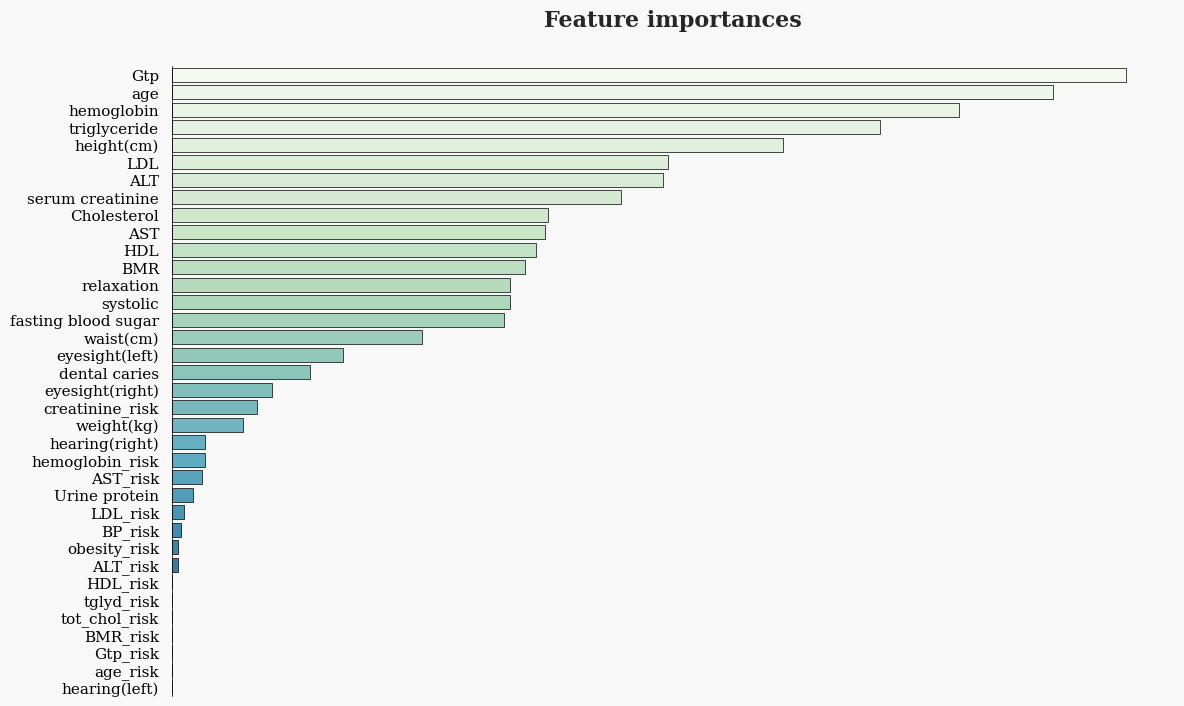

In [20]:
clf = LGBMClassifier()
clf.fit(df_train.drop(target,axis=1), df_train[target])

f_imp_df = pd.DataFrame({'feature': df_train.drop(target,axis=1).columns, 'imp': clf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

## Features Selection: RFECV

In [21]:
# clf = LGBMClassifier()
# rfe = RFECV(clf)
# X_rfe = rfe.fit_transform(df_train.drop(target,axis=1), df_train[target])
# clf.fit(X_rfe,df_train[target])

# cols = list(df_train.drop(target,axis=1).columns)
# temp = pd.Series(rfe.support_,index = cols)
# featureRFE = temp[temp==True].index.tolist()

In [22]:
featureRFE = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'BMR', 'creatinine_risk']
print(featureRFE)

['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'BMR', 'creatinine_risk']


In [23]:
evaluation(df=df_train,select_features=featureRFE,note='Feature RFE')

Feature RFE
Average ROC: 0.8606752250662938


0.8606752250662938

# 4. Modeling

In [24]:
X = df_train.drop(target,axis=1)

#X = df_train[featureRFE]
Y = df_train[target]

#df_pred = df_test[featureRFE]
df_pred = df_test

## Hill Climbing

In [25]:
def hill_climbing(x, y, x_test):

    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = roc_auc_score(y, x[col])

    # Sorting the model scores
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = True)}

    # Sort oof_df and test_preds
    x = x[list(scores.keys())]
    x_test = x_test[list(scores.keys())]

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    current_best_test_preds = x_test.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [roc_auc_score(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = roc_auc_score(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = roc_auc_score(y, potential_ensemble)
                if cv_score > potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            current_best_test_preds = (1 - wgt_best) * current_best_test_preds + wgt_best * x_test[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True

    hill_ens_pred_1 = current_best_ensemble
    hill_ens_pred_2 = current_best_test_preds

    return [hill_ens_pred_1, hill_ens_pred_2]

In [26]:
def training_model(clf,X_train,Y_train,X_test,Y_test,df_pred):
    clf.fit(X_train,Y_train)
    
    cv_pred = clf.predict_proba(X_test)[:, 1]
    cv_score = roc_auc_score(Y_test, cv_pred)
    pred = clf.predict_proba(df_pred)[:, 1]
    
    return cv_pred,cv_score,pred

In [27]:
models = {
    'RF': RandomForestClassifier(
                                  n_estimators = 500, 
                                   max_depth = 7,
                                   min_samples_split = 15,
                                   min_samples_leaf = 10),
    'ET': ExtraTreesClassifier(
                               n_estimators = 500, 
                                 max_depth = 7,
                                 min_samples_split = 15,
                                 min_samples_leaf = 10),
    'Hist': HistGradientBoostingClassifier(
                                            l2_regularization = 0.01,
                                             early_stopping = False,
                                             learning_rate = 0.01,
                                             max_iter = 500,
                                             max_depth = 5,
                                             max_bins = 255,
                                             min_samples_leaf = 15,
                                             max_leaf_nodes = 10),
    'LGBM': LGBMClassifier(
                            objective = 'binary',
                             n_estimators = 500,
                             max_depth = 7,
                             learning_rate = 0.01,
                             num_leaves = 20,
                             reg_alpha = 3,
                             reg_lambda = 3,
                             subsample = 0.7,
                             colsample_bytree = 0.7),
    'XGB': XGBClassifier(
                           objective = 'binary:logistic',
                           tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 2, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 500, 
                           subsample = 0.7),
        
    'Cat': CatBoostClassifier(
                                loss_function = 'Logloss',
                                iterations = 500,
                                learning_rate = 0.01,
                                depth = 7,
                                random_strength = 0.5,
                                bagging_temperature = 0.7,
                                border_count = 30,
                                l2_leaf_reg = 5,
                                verbose = False, 
                                task_type = 'CPU'),
    'Log': LogisticRegression(
                                random_state = 42, 
                                max_iter = 1000000),
    'Lda': LinearDiscriminantAnalysis(),
    'Gnb': GaussianNB(),
    'Bnb': BernoulliNB(),
    'Dart': LGBMClassifier(
                            random_state = 42, 
                            boosting_type = 'dart'),
    
}

model_preds = {} # To save predctions from each model

In [28]:
ens_cv_scores, ens_preds = list(), list()
hill_ens_cv_scores, hill_ens_preds =  list(), list()

sk = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)
for i, (train_idx, test_idx) in enumerate(sk.split(X, Y)):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    print('----------------------------------------------------------')
    
    for model_name, model in models.items():
        model_pred, model_score, model_pred_test = training_model(model, X_train, Y_train, X_test, Y_test, df_pred)
        print(f'Fold {i+1} ==> {model_name} oof ROC-AUC score is ==> {model_score}')
        
        model_preds[model_name] = (model_pred, model_pred_test)
    
    # Ensemble   
    ens_pred_1 = sum(pred[0] for pred in model_preds.values()) / len(models)
    ens_pred_2 = sum(pred[1] for pred in model_preds.values()) / len(models)
    
    ens_score_fold = roc_auc_score(Y_test, ens_pred_1)
    ens_cv_scores.append(ens_score_fold)
    ens_preds.append(ens_pred_2)
    
    # Hill Climbing Ensemble
    x = pd.DataFrame({model_name: model_preds[model_name][0] for model_name in models})
    y = Y_test

    x_test = pd.DataFrame({model_name: model_preds[model_name][1] for model_name in models})

    hill_results = hill_climbing(x, y, x_test)

    hill_ens_score_fold = roc_auc_score(y, hill_results[0])
    hill_ens_cv_scores.append(hill_ens_score_fold)
    hill_ens_preds.append(hill_results[1])

    print(f'Fold {i+1} ==> Hill Climbing Ensemble oof ROC-AUC score is ==> {hill_ens_score_fold}')
    print(f'Fold {i+1} ==> Average Ensemble oof ROC-AUC score is ==> {ens_score_fold}')

    print('The hill climbing ensemble oof ROC-AUC score over the 5-folds is', np.mean(hill_ens_cv_scores))

----------------------------------------------------------
Fold 1 ==> RF oof ROC-AUC score is ==> 0.8432307307768601
Fold 1 ==> ET oof ROC-AUC score is ==> 0.8321739783034395
Fold 1 ==> Hist oof ROC-AUC score is ==> 0.8541866276674377
Fold 1 ==> LGBM oof ROC-AUC score is ==> 0.8586669578130163
Fold 1 ==> XGB oof ROC-AUC score is ==> 0.8633826376267375
Fold 1 ==> Cat oof ROC-AUC score is ==> 0.8591273944228531
Fold 1 ==> Log oof ROC-AUC score is ==> 0.8430260885202233
Fold 1 ==> Lda oof ROC-AUC score is ==> 0.8433057145969124
Fold 1 ==> Gnb oof ROC-AUC score is ==> 0.7946584983979373
Fold 1 ==> Bnb oof ROC-AUC score is ==> 0.7829446552579141
Fold 1 ==> Dart oof ROC-AUC score is ==> 0.8583772813511342
Fold 1 ==> Hill Climbing Ensemble oof ROC-AUC score is ==> 0.8648210711621072
Fold 1 ==> Average Ensemble oof ROC-AUC score is ==> 0.8474946421937161
The hill climbing ensemble oof ROC-AUC score over the 5-folds is 0.8648210711621072
---------------------------------------------------------

In [29]:
hill_preds_test = pd.DataFrame(hill_ens_preds).apply(np.mean, axis = 0)

hill_ensemble_submission = sample_submission.copy()

hill_ensemble_submission['smoking'] = hill_preds_test
hill_ensemble_submission.to_csv('Ensemble_submission.csv', index = False)

In [30]:
roc_results

,Selected_Features,ROC
0,Baseline,0.860780
1,Feature RFE,0.860675


# 5. Hyperparameter optimization of individual models

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.1, random_state = 42)

## LGBM

In [32]:
def objective_lgb(trial):
    params = {
        'metric': trial.suggest_categorical('metric', ['binary_error']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }


    model_lgb = LGBMClassifier(seed=42,device='gpu',**params)
    model_lgb.fit(X_train, y_train)
    y_pred = model_lgb.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [33]:
opt_lgb = optuna.create_study(direction='maximize')
opt_lgb.optimize(objective_lgb, n_trials=1000,show_progress_bar=True)

[I 2023-10-24 14:21:37,947] A new study created in memory with name: no-name-050462d6-c35f-48c0-a9bc-5bd9748a7467


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-10-24 14:21:50,810] Trial 0 finished with value: 0.7724475383373689 and parameters: {'metric': 'binary_error', 'max_depth': 10, 'min_child_samples': 7, 'learning_rate': 0.013109702532525502, 'n_estimators': 466, 'min_child_weight': 8, 'subsample': 0.15877295038467265, 'colsample_bytree': 0.5812298834379698, 'reg_alpha': 0.044717383595364146, 'reg_lambda': 0.2722626756299932}. Best is trial 0 with value: 0.7724475383373689.
[I 2023-10-24 14:21:55,045] Trial 1 finished with value: 0.7744148506860371 and parameters: {'metric': 'binary_error', 'max_depth': 4, 'min_child_samples': 13, 'learning_rate': 0.049528066103688984, 'n_estimators': 394, 'min_child_weight': 10, 'subsample': 0.6352476965144737, 'colsample_bytree': 0.7983023274308024, 'reg_alpha': 0.42653132775949876, 'reg_lambda': 0.9099621169719665}. Best is trial 1 with value: 0.7744148506860371.
[I 2023-10-24 14:22:01,377] Trial 2 finished with value: 0.7724475383373689 and parameters: {'metric': 'binary_error', 'max_depth':

In [34]:
opt_lgb_params = opt_lgb.best_params
opt_lgb_params

{'metric': 'binary_error',
 'max_depth': 6,
 'min_child_samples': 10,
 'learning_rate': 0.04867544846867034,
 'n_estimators': 693,
 'min_child_weight': 10,
 'subsample': 0.8568865597695615,
 'colsample_bytree': 0.6005326636887391,
 'reg_alpha': 0.7459260374418606,
 'reg_lambda': 0.5019954618928616}

In [35]:
opt_lgb_model = LGBMClassifier(**opt_lgb_params).fit(X_train, y_train)
opt_lgb_pred = opt_lgb_model.predict_proba(df_pred)[:, 1]

opt_lgb_submission = pd.DataFrame({'id': sample_submission['id'], 'smoking': opt_lgb_pred})
opt_lgb_submission.to_csv('opt_lgb_submission.csv',index=False)

In [36]:
opt_lgb_submission.head(3)

,id,smoking
0,159256,0.627766
1,159257,0.368146
2,159258,0.371267


## XGBoost

In [37]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.3, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }
    model_xgb = XGBClassifier(booster='gbtree',tree_method='gpu_hist',objective='binary:logistic',seed=42,**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)
    return accuracy_score(y_test,y_pred)

In [38]:
opt_xgb = optuna.create_study(direction='maximize')
opt_xgb.optimize(objective_xgb, n_trials=1000,show_progress_bar=True)

[I 2023-10-24 16:46:31,939] A new study created in memory with name: no-name-601afa5a-e04e-433e-92c1-17c912ec5739


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2023-10-24 16:46:35,400] Trial 0 finished with value: 0.7750706214689266 and parameters: {'max_depth': 6, 'learning_rate': 0.01059255723284618, 'n_estimators': 808, 'min_child_weight': 9, 'gamma': 0.46342423143262096, 'subsample': 0.310530909236571, 'reg_alpha': 0.8741954599678432, 'reg_lambda': 0.13261557529755527}. Best is trial 0 with value: 0.7750706214689266.
[I 2023-10-24 16:46:43,433] Trial 1 finished with value: 0.7809221146085553 and parameters: {'max_depth': 10, 'learning_rate': 0.013316267175563787, 'n_estimators': 749, 'min_child_weight': 4, 'gamma': 0.001167144872254089, 'subsample': 0.5250441162859986, 'reg_alpha': 0.43397079035600433, 'reg_lambda': 0.22498061004234876}. Best is trial 1 with value: 0.7809221146085553.
[I 2023-10-24 16:46:48,532] Trial 2 finished with value: 0.7813761097659403 and parameters: {'max_depth': 8, 'learning_rate': 0.040280006101286854, 'n_estimators': 870, 'min_child_weight': 3, 'gamma': 4.650515419730879e-07, 'subsample': 0.641595765297524,

In [39]:
opt_xgb_params = opt_xgb.best_params
opt_xgb_params

{'max_depth': 10,
 'learning_rate': 0.04522166615928481,
 'n_estimators': 900,
 'min_child_weight': 2,
 'gamma': 1.5761387516476945e-07,
 'subsample': 0.8051214395892462,
 'reg_alpha': 0.9255291450939404,
 'reg_lambda': 0.7278543598793059}

In [40]:
opt_xgb_model = XGBClassifier(**opt_xgb_params).fit(X_train, y_train)
opt_xgb_pred = opt_xgb_model.predict_proba(df_pred)[:, 1]

opt_xgb_submission = pd.DataFrame({'id': sample_submission['id'], 'smoking': opt_xgb_pred})
opt_xgb_submission.to_csv('opt_xgb_submission.csv',index=False)

In [41]:
opt_xgb_submission.head(3)

,id,smoking
0,159256,0.749381
1,159257,0.233436
2,159258,0.401791


## Voting Model

In [42]:
voting = VotingClassifier(estimators=[
                                      ('lgbm', opt_lgb_model), 
                                      ('xgb', opt_xgb_model)], voting='soft')
voting.fit(X,Y)

opt_voting_pred = voting.predict_proba(df_pred)[:, 1]

opt_voting_submission = pd.DataFrame({'id': sample_submission['id'], 'smoking': opt_voting_pred})
opt_voting_submission.to_csv('opt_voting_submission.csv',index=False)

In [43]:
opt_voting_submission.head(3)

,id,smoking
0,159256,0.666769
1,159257,0.294305
2,159258,0.375313


# 6. NN by pytorch

In [44]:
train_set = torch.tensor(X.values,dtype=torch.float32).to(device)
train_target = torch.tensor(Y.values,dtype=torch.float32).to(device)

pred_set = torch.tensor(df_pred.values,dtype=torch.float32).to(device)

In [45]:
input_dim = train_set.shape[1]

In [46]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim1=64, hidden_dim2=32):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)  
        self.dropout1 = nn.Dropout(0.2)  
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

In [47]:
model = NN(input_dim).to(device)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.0001)

loss_history = []

epochs = 1000
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(train_set).squeeze()
    
    loss = criterion(outputs, train_target)
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
    loss.backward()    
    optimizer.step()
train_steps = range(1, len(loss_history) + 1)

Epoch [10/1000], Loss: 0.6918
Epoch [20/1000], Loss: 0.6684
Epoch [30/1000], Loss: 0.6489
Epoch [40/1000], Loss: 0.6323
Epoch [50/1000], Loss: 0.6178
Epoch [60/1000], Loss: 0.6063
Epoch [70/1000], Loss: 0.5957
Epoch [80/1000], Loss: 0.5864
Epoch [90/1000], Loss: 0.5814
Epoch [100/1000], Loss: 0.5748
Epoch [110/1000], Loss: 0.5686
Epoch [120/1000], Loss: 0.5646
Epoch [130/1000], Loss: 0.5614
Epoch [140/1000], Loss: 0.5568
Epoch [150/1000], Loss: 0.5537
Epoch [160/1000], Loss: 0.5511
Epoch [170/1000], Loss: 0.5485
Epoch [180/1000], Loss: 0.5453
Epoch [190/1000], Loss: 0.5438
Epoch [200/1000], Loss: 0.5422
Epoch [210/1000], Loss: 0.5396
Epoch [220/1000], Loss: 0.5375
Epoch [230/1000], Loss: 0.5357
Epoch [240/1000], Loss: 0.5338
Epoch [250/1000], Loss: 0.5322
Epoch [260/1000], Loss: 0.5312
Epoch [270/1000], Loss: 0.5292
Epoch [280/1000], Loss: 0.5283
Epoch [290/1000], Loss: 0.5269
Epoch [300/1000], Loss: 0.5251
Epoch [310/1000], Loss: 0.5244
Epoch [320/1000], Loss: 0.5237
Epoch [330/1000],

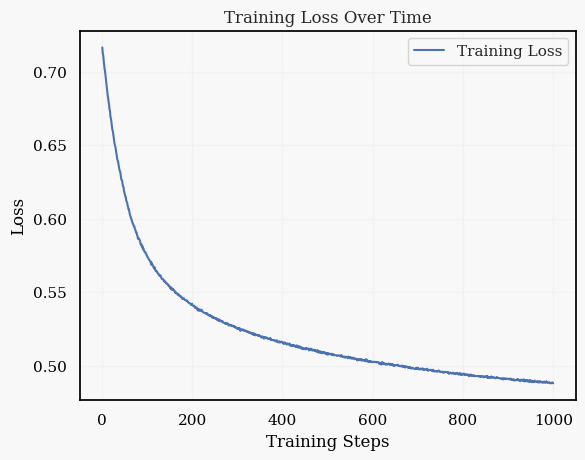

In [48]:
plt.plot(train_steps, loss_history, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Time')
plt.show()

## Prediction

In [49]:
model.eval()
with torch.no_grad():
    probs = model(pred_set)
    
probs = probs.cpu().flatten().numpy()
nn_submission = pd.DataFrame({'id': sample_submission['id'], 'smoking': probs})
nn_submission.to_csv('nn_submission.csv',index=False)

In [50]:
nn_submission.head(3)

,id,smoking
0,159256,0.656320
1,159257,0.332996
2,159258,0.576353


# 7. Autogluon Baseline (Removed after version 10) 

In [51]:
# !pip install autogluon
# from autogluon.tabular import TabularDataset, TabularPredictor

# predictor = TabularPredictor(label=target).fit(df_train)
# preds = predictor.predict_proba(df_test)
# auto_submission = sample_submission.copy()
# auto_submission['smoking'] = preds[1].values
# auto_submission.to_csv('auto_submission.csv',index=False)
# auto_submission.head()